### Visualise Players

In [5]:
import os

import pandas as pd
from matplotlib import pyplot as plt
from mplsoccer import Pitch

In [7]:
cd ~

/Users/jamesdavies


In [8]:
cd soccermatics

/Users/jamesdavies/soccermatics


In [26]:
pitch_length = 105
pitch_width = 68

def transform_x_coordinates(x):
    return x / pitch_length * 100


def transform_y_coordinates(x):
    return 100 - (x / pitch_width * 100)

# CL Finals
match_id = 18768058

# Load tracking data frames from Tutorial 1
df_tracking = pd.read_parquet(f"data/tracking_data/{match_id}_tracks.parquet")

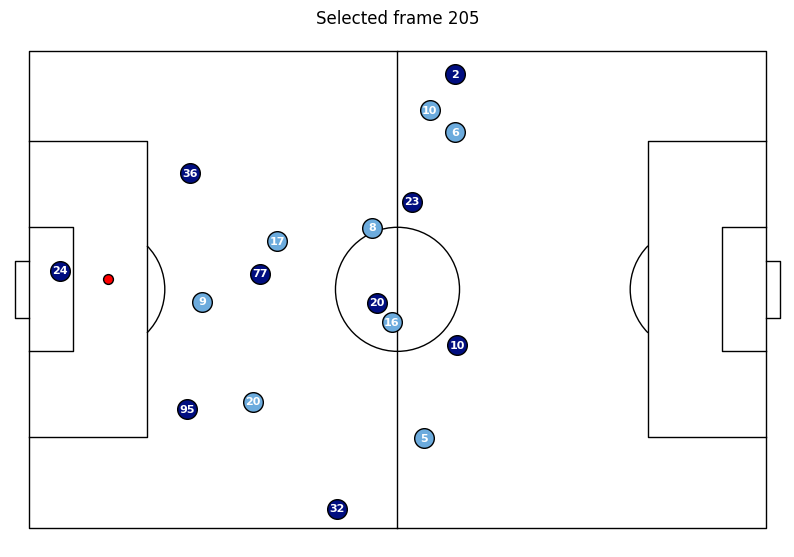

In [23]:
# Select frame and period from df_tracking
frame, period = df_tracking.iloc[300][['frame', 'period']]

# Filter the DataFrame to get the selected frame and period
selected_frame = df_tracking[(df_tracking['frame'] == frame) & (df_tracking['period'] == period)].copy()

# Transform coordinates to wyscout (Use .loc to avoid SettingWithCopyWarning)
selected_frame.loc[:, 'start_x'] = transform_x_coordinates(selected_frame['x'])
selected_frame.loc[:, 'start_y'] = transform_y_coordinates(selected_frame['y'])

# Set team colors
team_colors = {
    'Manchester City': '#6cabdd',
    'Inter': '#010E80',
}

# Create the pitch plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pitch = Pitch(pitch_type="wyscout",
              goal_type='box',
              pitch_color="w",
              linewidth=1,
              spot_scale=0,
              line_color="k",
              line_zorder=1)

# Draw the pitch
pitch.draw(ax)

# Add players
for team, players in selected_frame.groupby('team_name'):

    # Add player positions as nodes
    pitch.scatter(
        players['start_x'],
        players['start_y'],
        color='r' if team == 'ball' else team_colors.get(team, 'k'),
        ec = 'k',
        ax=ax,
        lw = 1,
        zorder=3 if team=='ball' else 2, # ball order priority
        s= 50 if team=='ball' else 200, #Different size for ball

    )

    # Add jersey numbers to nodes, ignore ball
    for idx, row in players[players['team_name']!='ball'].iterrows():
        pitch.annotate(row['jersey_number'], xy=(row['start_x'], row['start_y']),
                           c='w', va='center',
                           zorder=4,
                           ha='center', size=8,
                            weight='bold',
                           alpha=1,
                           ax=ax)


# Add title
ax.set_title(f"Selected frame {frame}")

# Output image
os.makedirs("outputs",exist_ok=True)
fig.savefig(f"outputs/freeze_frame_{frame}_{period}.jpg", format='jpg', dpi=200, facecolor=fig.get_facecolor())



### Visualise xG Chain Runs

In [12]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from mplsoccer import Pitch

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/2620545903.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)


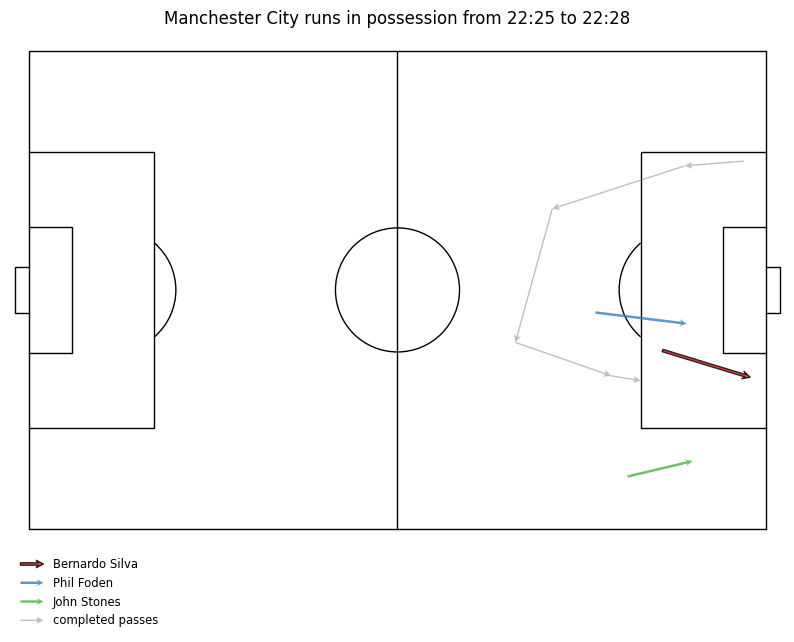

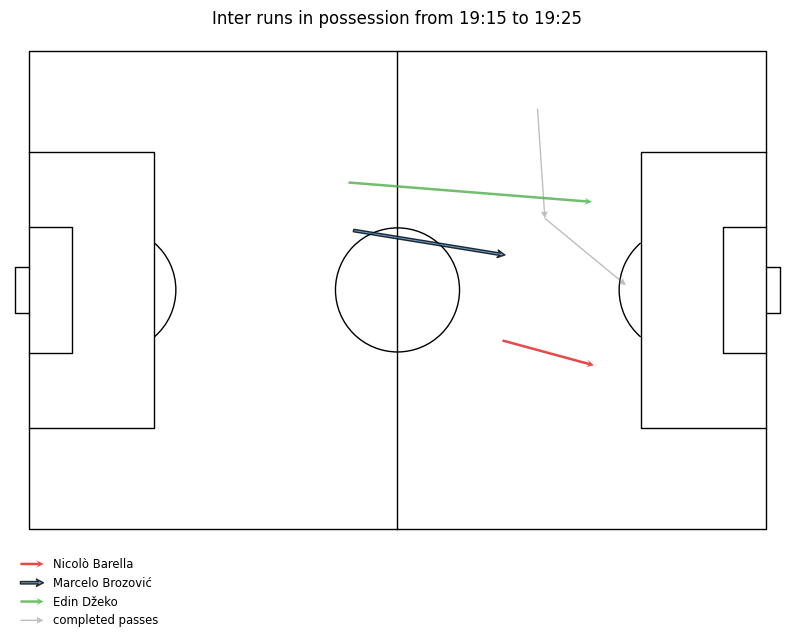

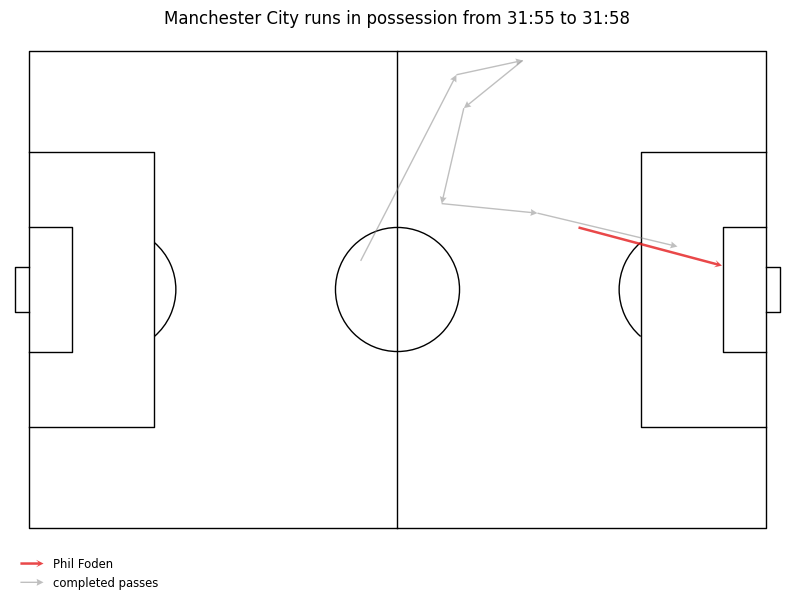

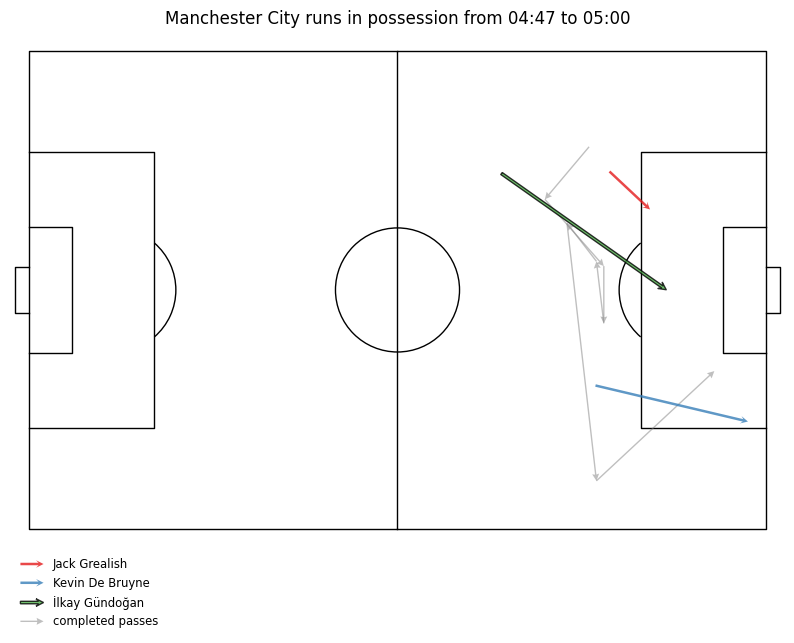

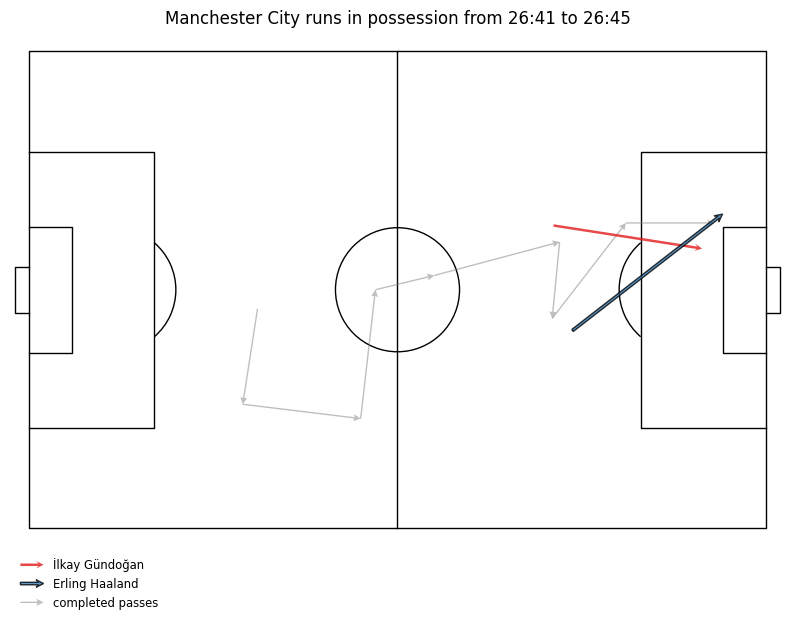

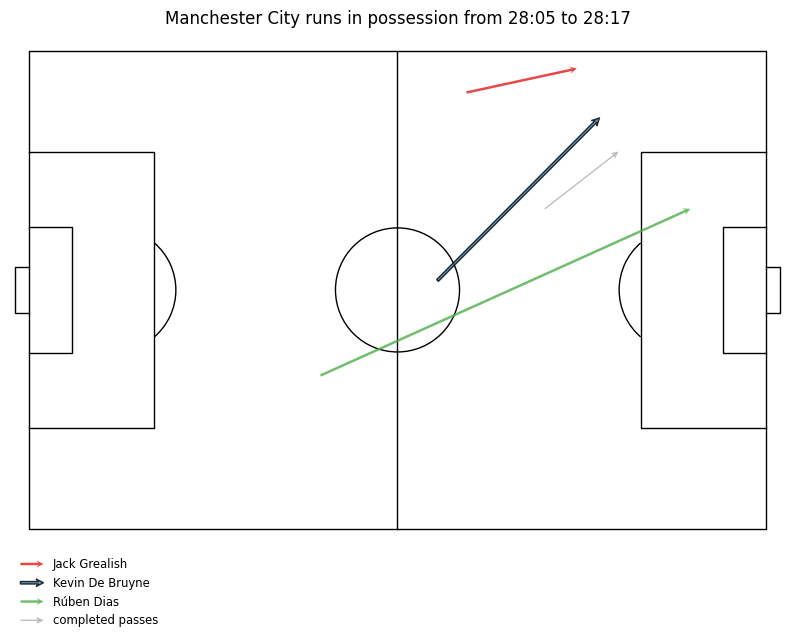

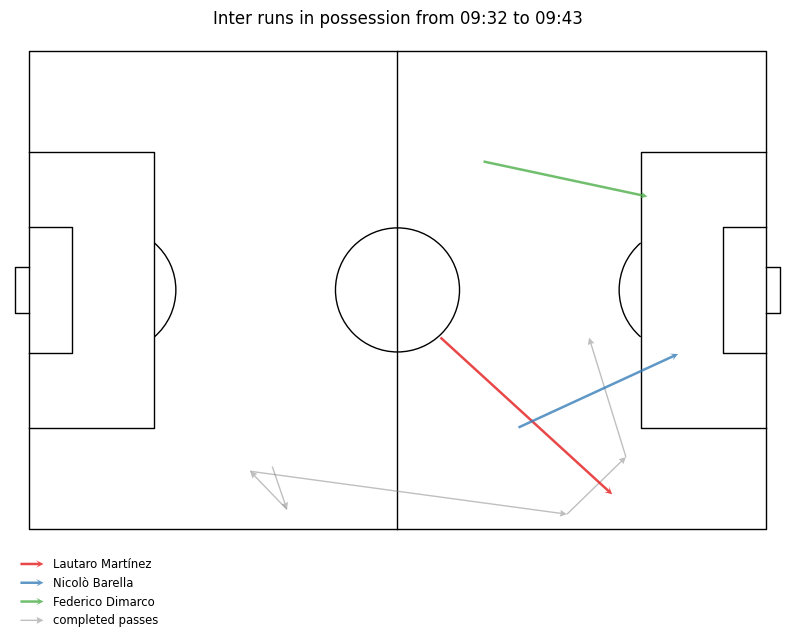

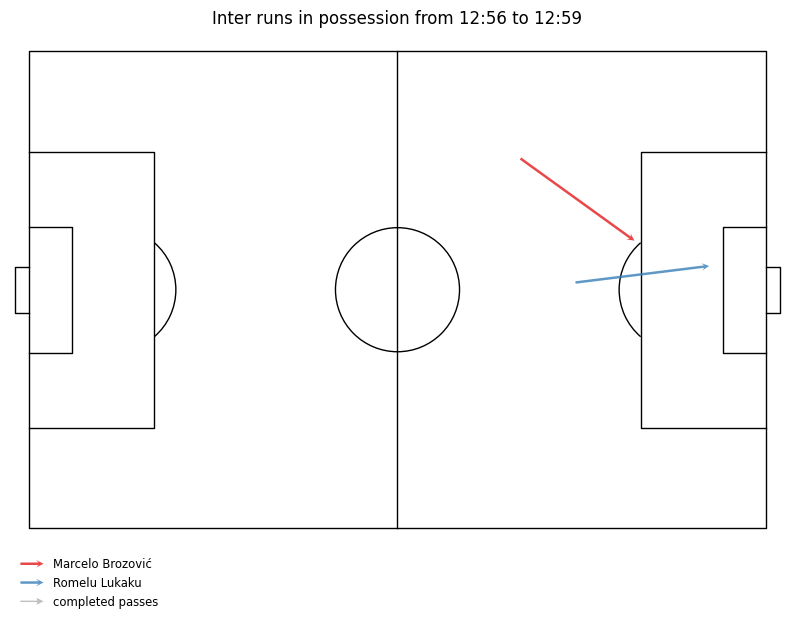

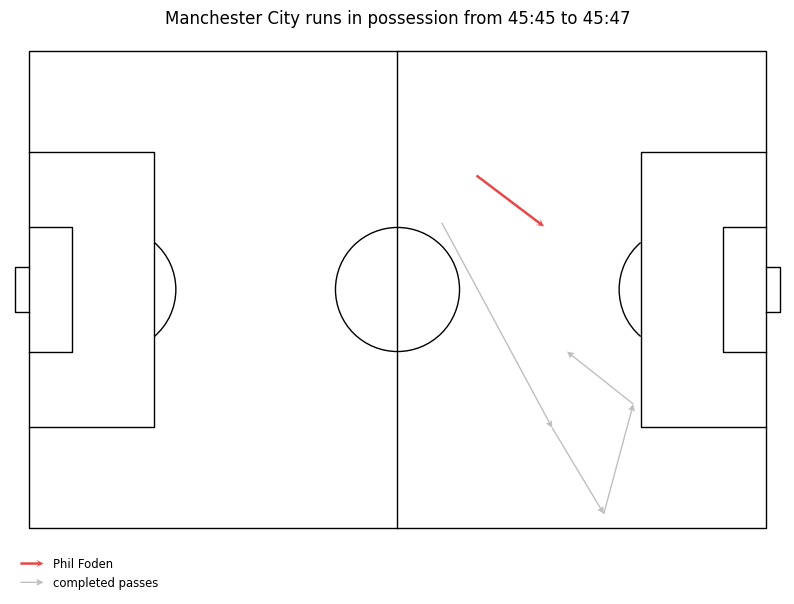

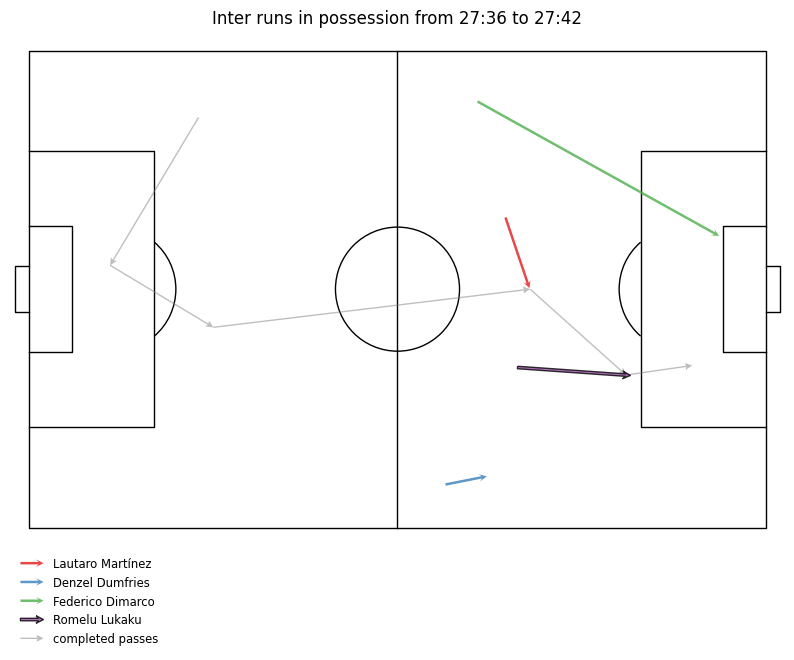

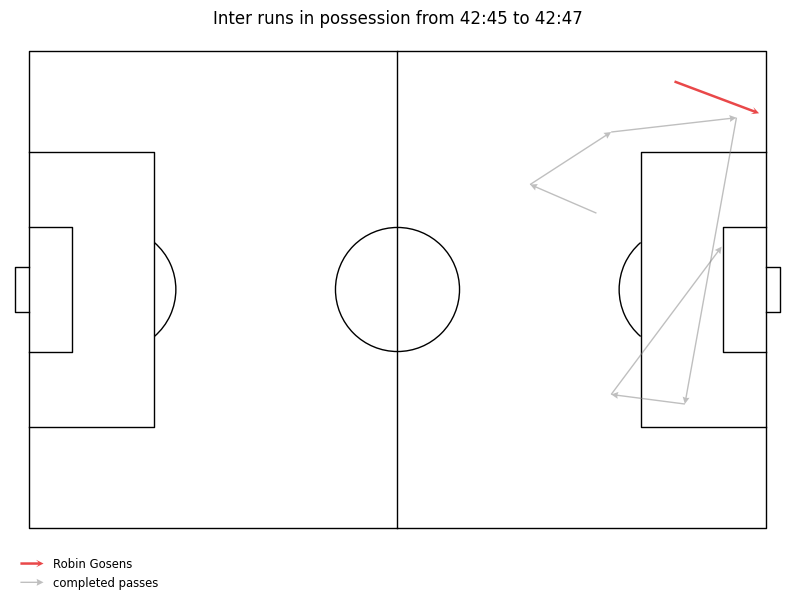

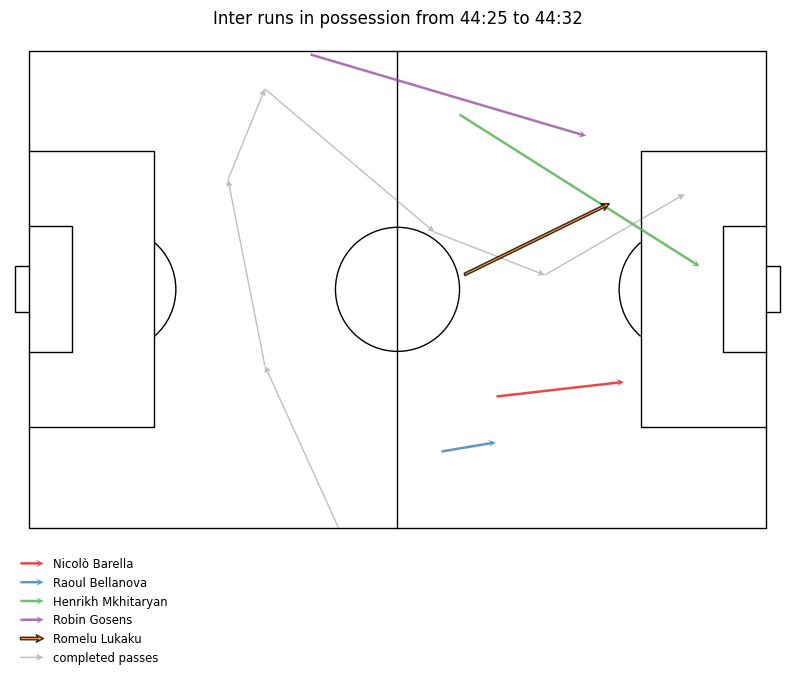

In [13]:
# CL Finals
match_id = 18768058

# Load wyscout event data - Coordinates are transformed to opta
df_events = pd.read_parquet(f"data/tracking_data/{match_id}_stories.parquet")

# Load pre-generated "runs" data
df_runs = pd.read_parquet(f"data/tracking_data/{match_id}_runs.parquet")

# Find all runs in possession when shot occurs
xg_runs = df_runs[df_runs['xGRun'] > 0]

# Group all runs into one possession

visualize_passing_chain = True
for possession_id, df_runs in xg_runs.groupby('possession_id'):

    # get team events in a possession
    df_possession = df_events[(df_events['possession_id'] == possession_id)&(df_events['possession_team_id'] == df_events['team_id'])]

    # Player can have multiple runs in on possession, keep only his last run
    df_runs = df_runs.drop_duplicates(subset='player', keep='last')

    # Plot all runs in possession
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
    pitch = Pitch(pitch_type="opta",
                  goal_type='box',
                  pitch_color="w",
                  linewidth=1,
                  spot_scale=0,
                  line_color="k",
                  line_zorder=1)

    pitch.draw(ax)

    # Create color set
    name = "Set1"
    cmap = get_cmap(name)
    colors = cmap.colors
    counter = 0

    # Plot all runs
    for idx, row in df_runs.iterrows():

        # Visualize runs -
        pitch.arrows(row['start_x'], row['start_y'],
                          row['end_x'], row['end_y'],
                          width= 1.8,
                          headwidth=3, headlength=3, headaxislength=2,
                          color=colors[counter],
                          edgecolor= "k" if row['Target'] else colors[counter], # Differentiate target and off target runs
                          linewidth=1 if row['Target'] else 0, # Differentiate target and off target runs
                          alpha=0.8,
                          zorder=3,
                          label=row['player'],
                          ax=ax)

        counter += 1
        if counter >= len(colors):
            counter = 0

    # Visualize possession chain
    if visualize_passing_chain:
        pitch.arrows(df_possession[df_possession['end_x'].between(1, 100)]['start_x'],
                         df_possession[df_possession['end_x'].between(1, 100)]['start_y'],
                         df_possession[df_possession['end_x'].between(1, 100)]['end_x'],
                         df_possession[df_possession['end_x'].between(1, 100)]['end_y'], width=1, headwidth=5,
                         alpha=0.5, ls='--', zorder=2,
                         headlength=5, color='grey', ax=ax, label='completed passes')

    # Add title
    possession_start_time = df_runs['time_start'].min()[0:5]
    possession_end_time = df_runs['time_end'].max()[0:5]
    team_name = df_runs.iloc[0]['team_name']
    ax.set_title(f"{team_name} runs in possession from {possession_start_time} to {possession_end_time}")

    # Legend
    ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize='small', framealpha=0.0, ncol=1)

    # Save output image
    #os.makedirs("outputs", exist_ok=True)
    #fig.savefig(f"outputs/runs_{possession_id}.jpg", format='jpg', dpi=200, facecolor=fig.get_facecolor())

#### Track for One Player 

In [14]:
import numpy as np

# Filter the data for a specific player
player_data = df_tracking[df_tracking['player'] == 'John Stones']

# Compute direction angles
player_data['theta'] = np.arctan2(player_data['vy'], player_data['vx'])

# Convert angles to unit vectors
cos_theta = np.cos(player_data['theta'])
sin_theta = np.sin(player_data['theta'])

# Calculate the average direction vector
avg_vx = cos_theta.mean()
avg_vy = sin_theta.mean()

# Average direction (in radians)
avg_direction = np.arctan2(avg_vy, avg_vx)

# Mean resultant length (measure of directional consistency)
mean_resultant_length = np.sqrt(avg_vx**2 + avg_vy**2)

# Display the results
print(f"Average Direction (radians): {avg_direction}")
print(f"Mean Resultant Length: {mean_resultant_length}")

Average Direction (radians): -0.2738876106718632
Mean Resultant Length: 0.019412130036894255


/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/889688560.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['theta'] = np.arctan2(player_data['vy'], player_data['vx'])


In [15]:
df_runs.end_x.max()

90.97004185587747

In [21]:
df_runs.start_y.max()

99.35298810750645

### Plot player runs into the final third

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


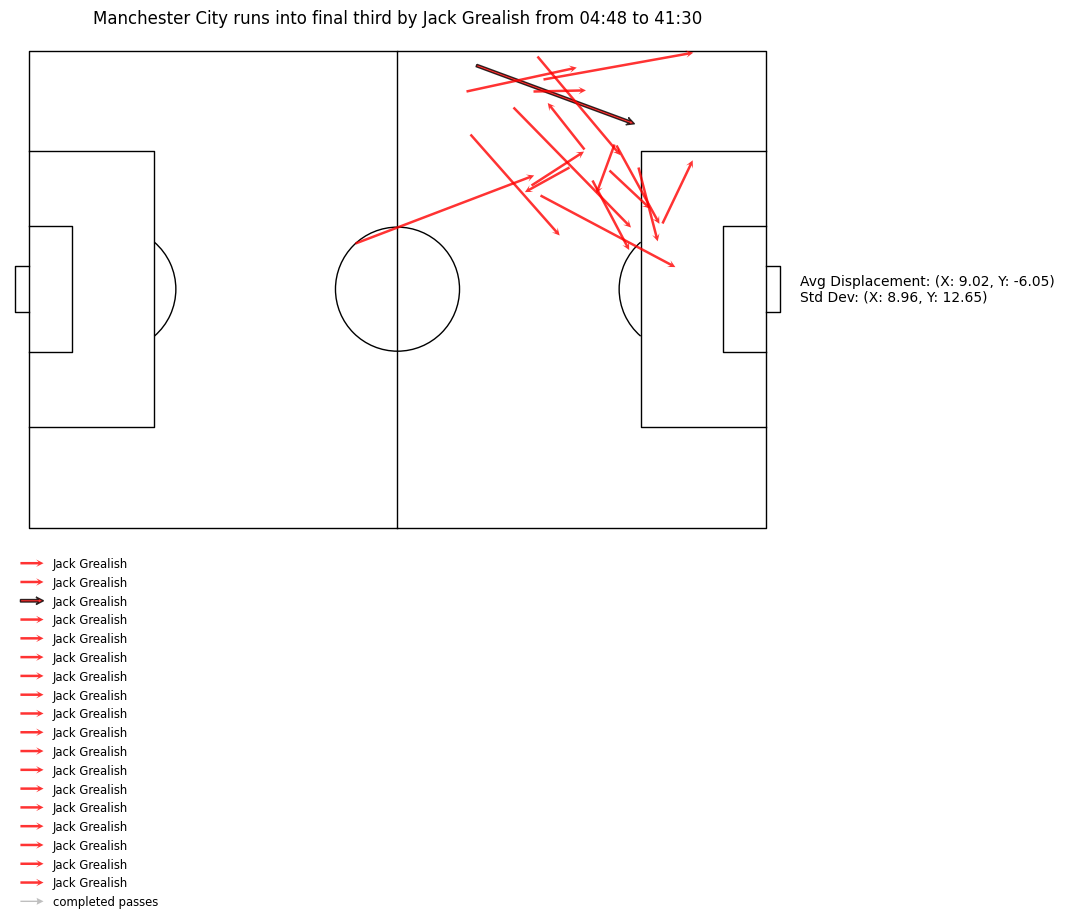

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


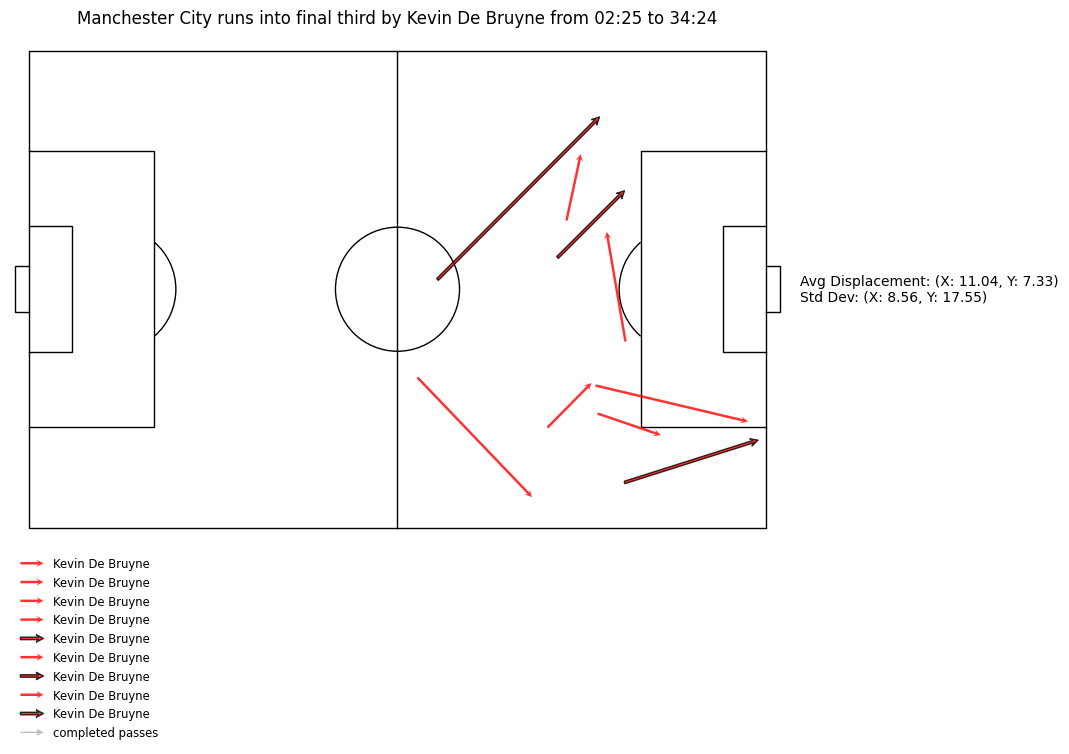

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


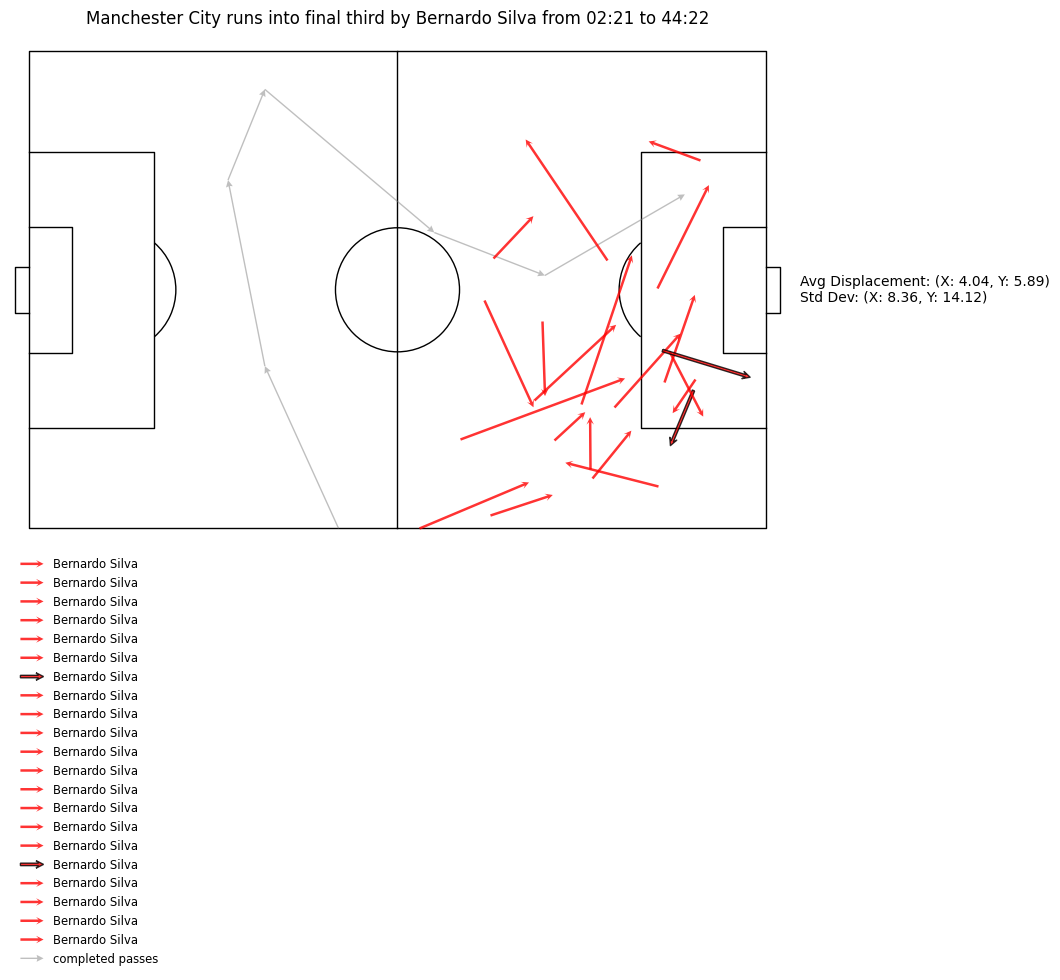

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


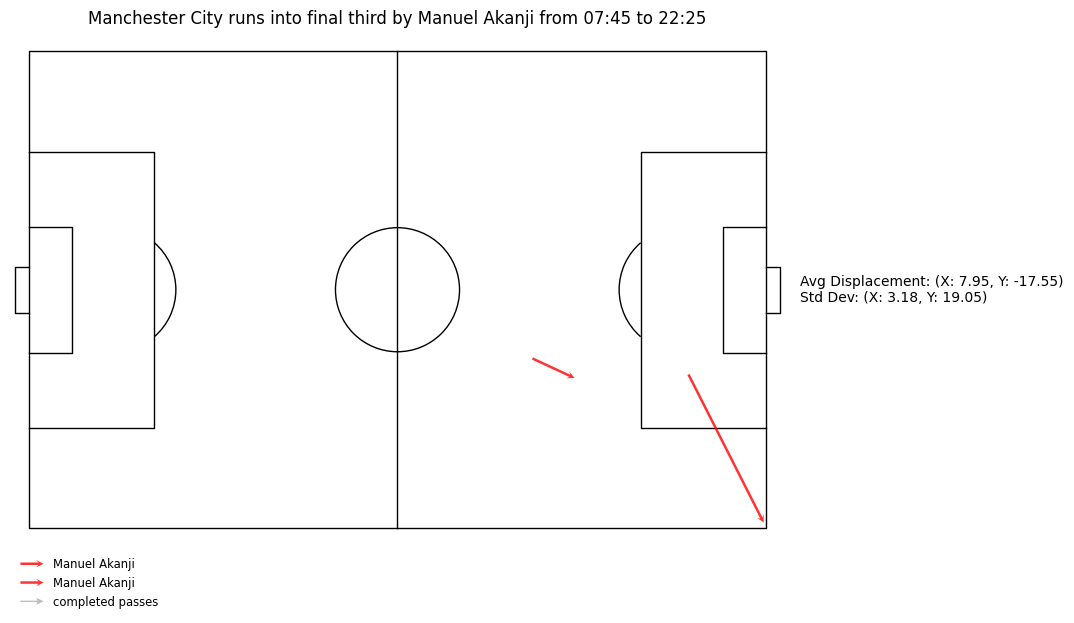

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


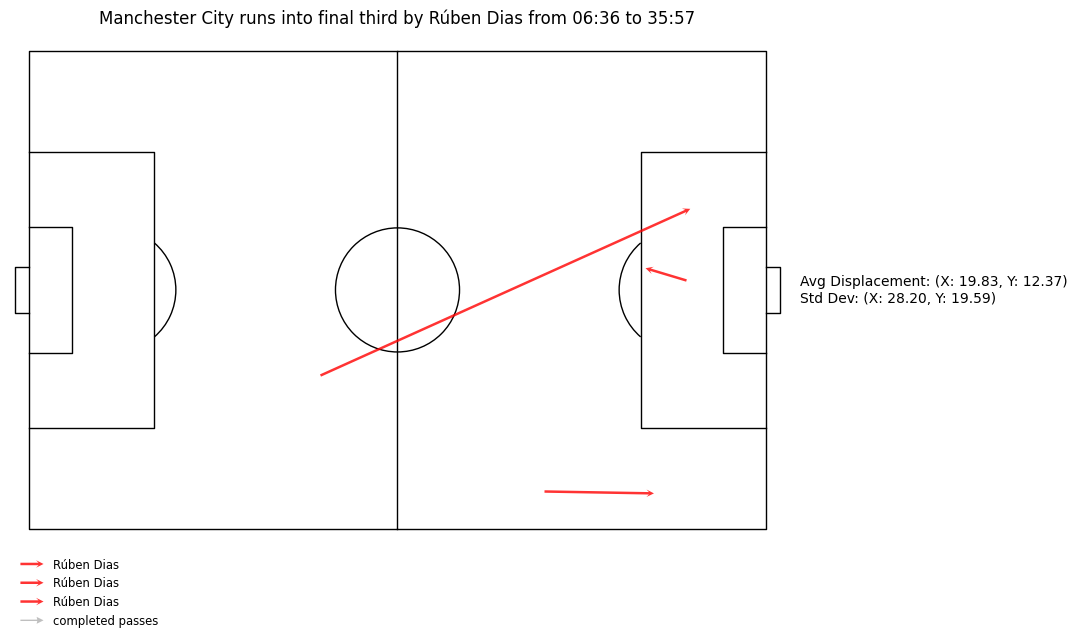

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


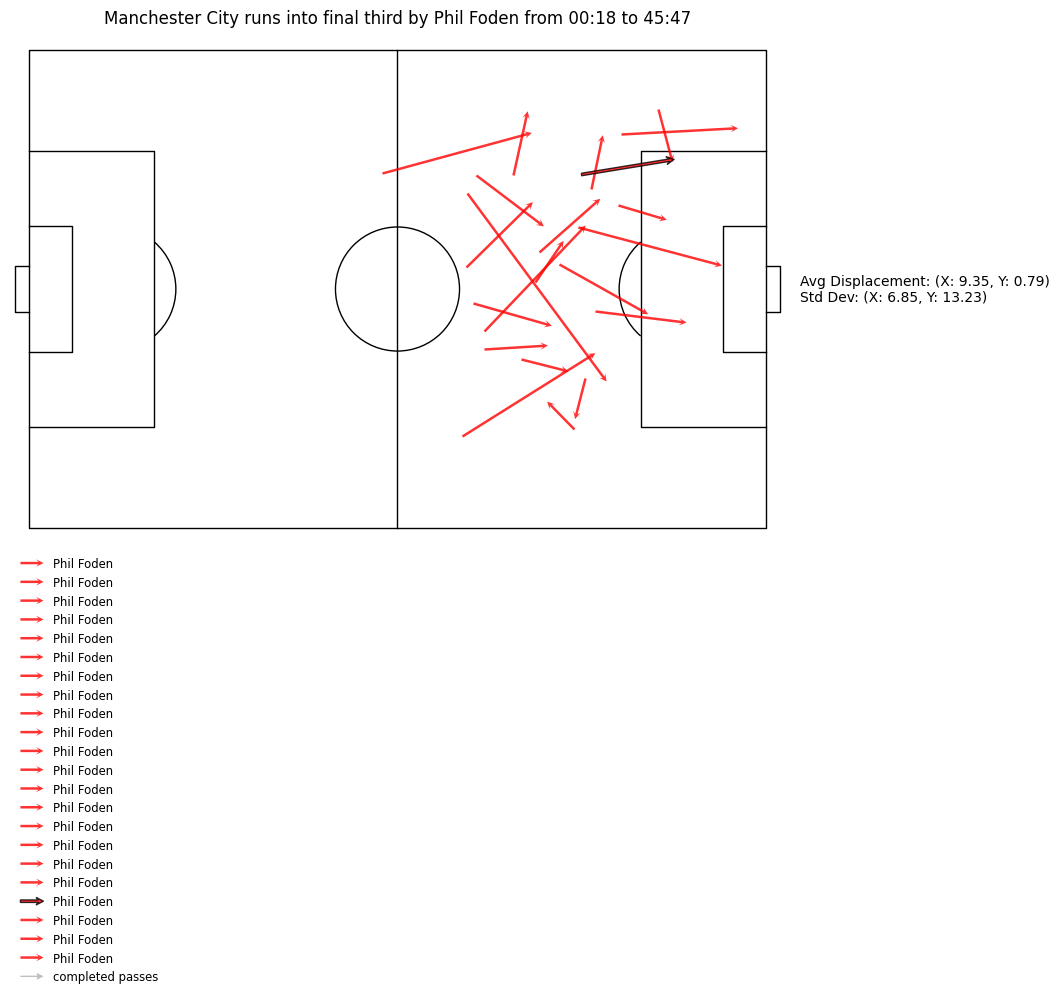

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


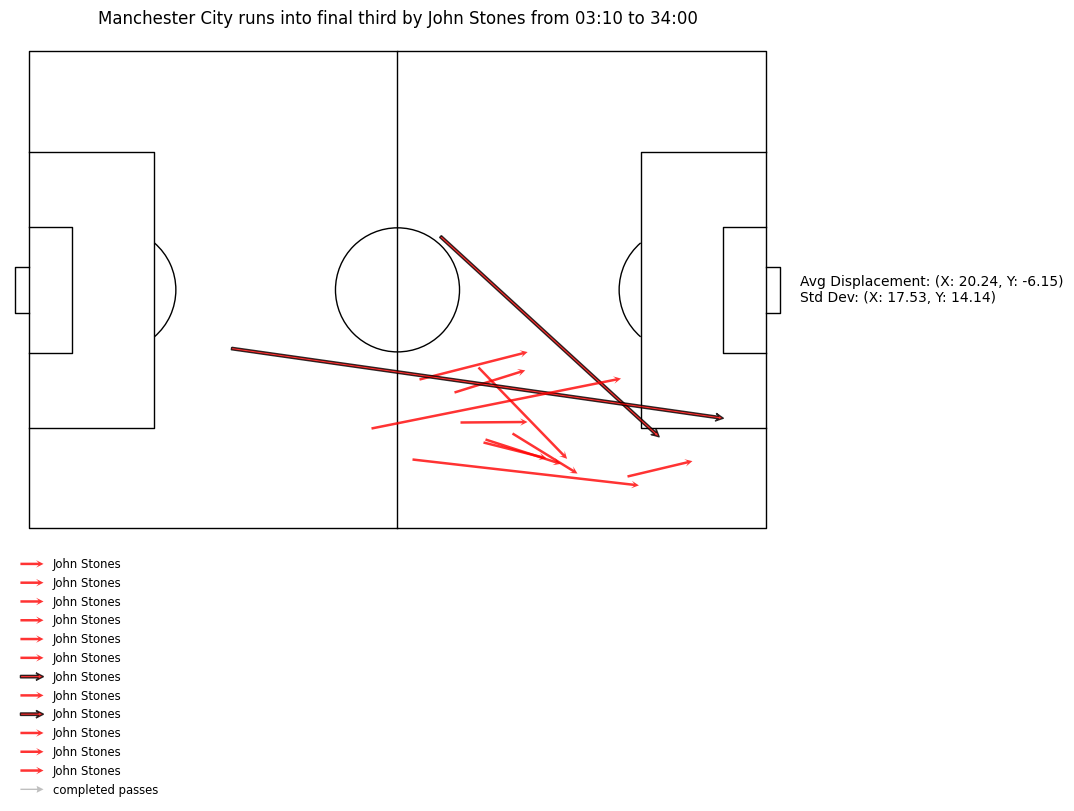

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


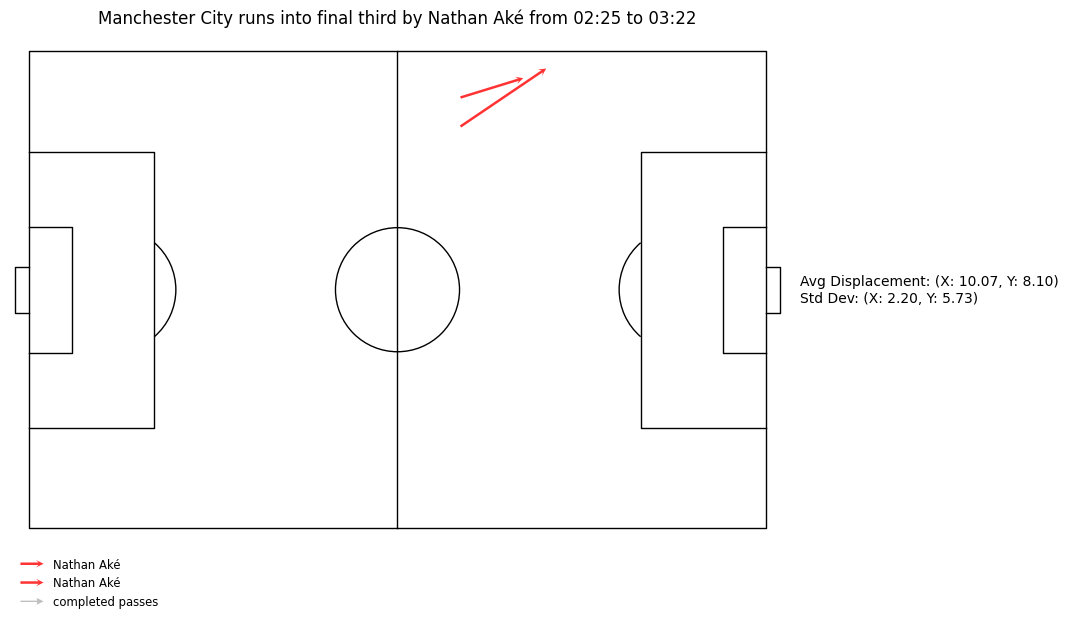

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


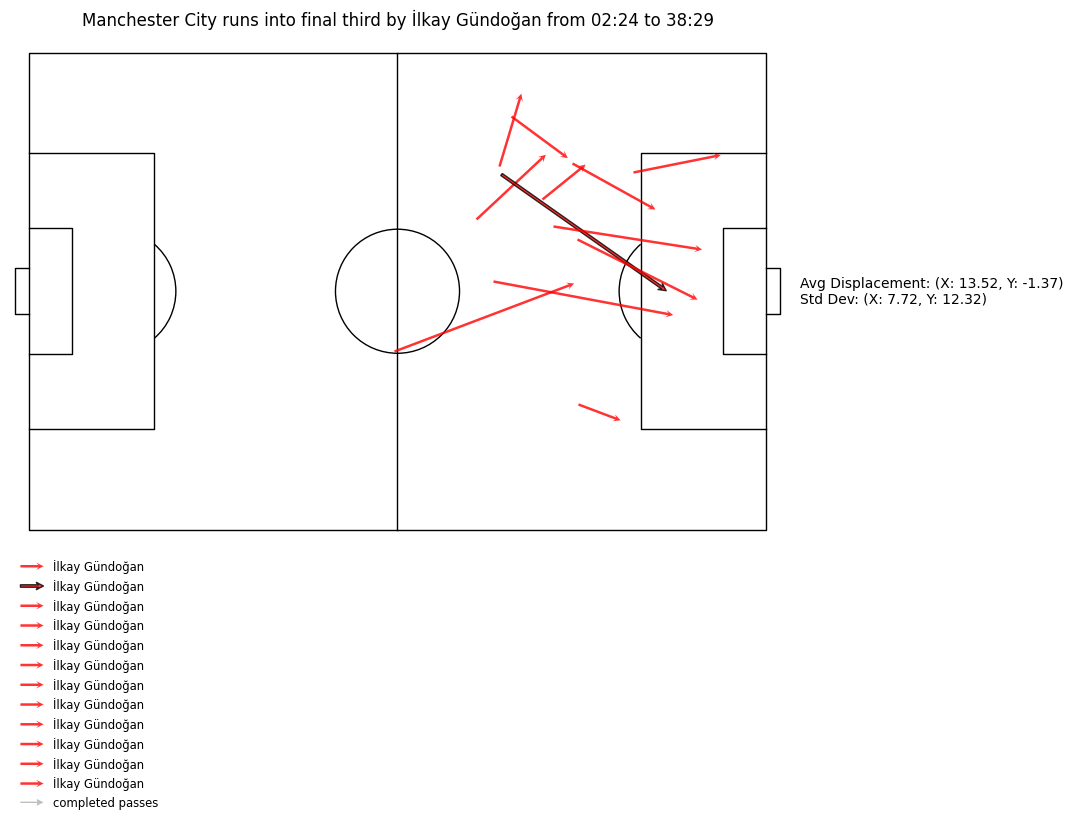

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


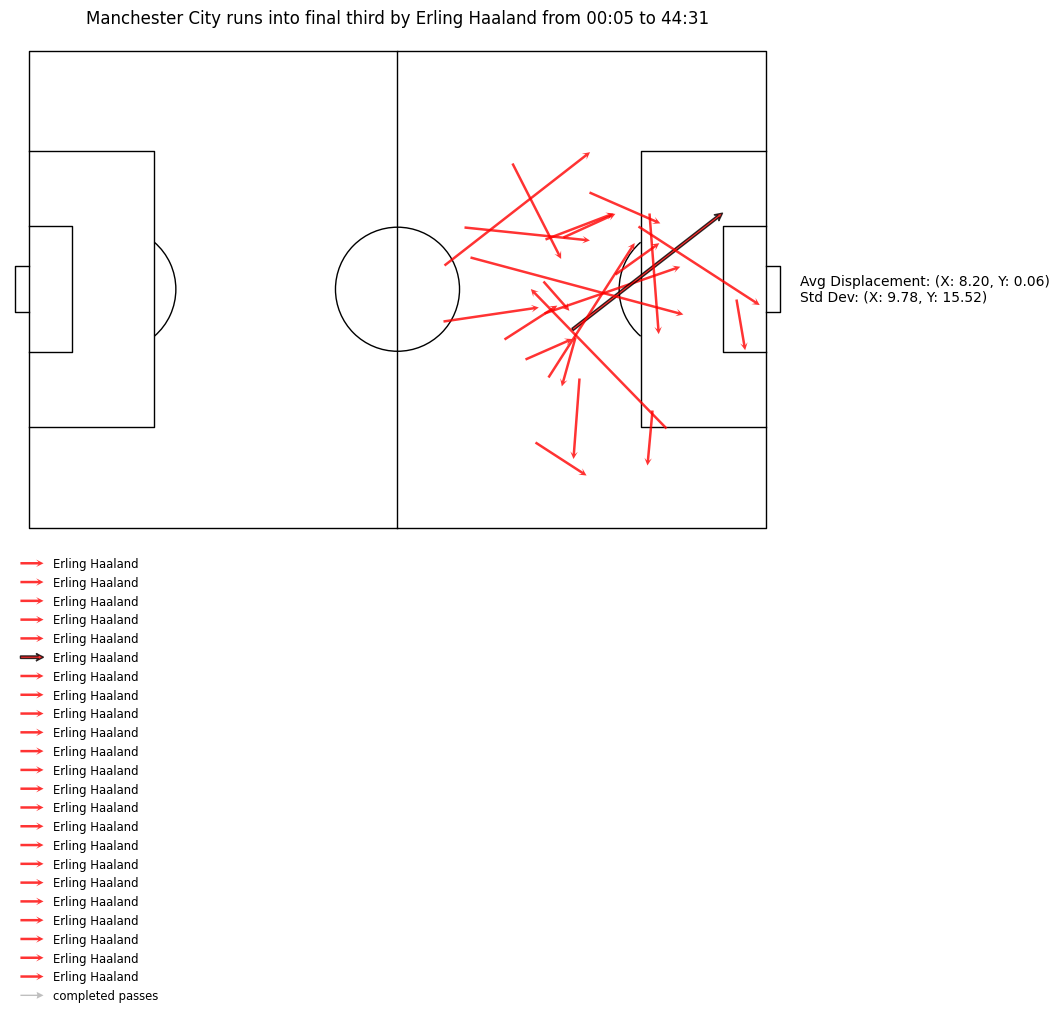

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


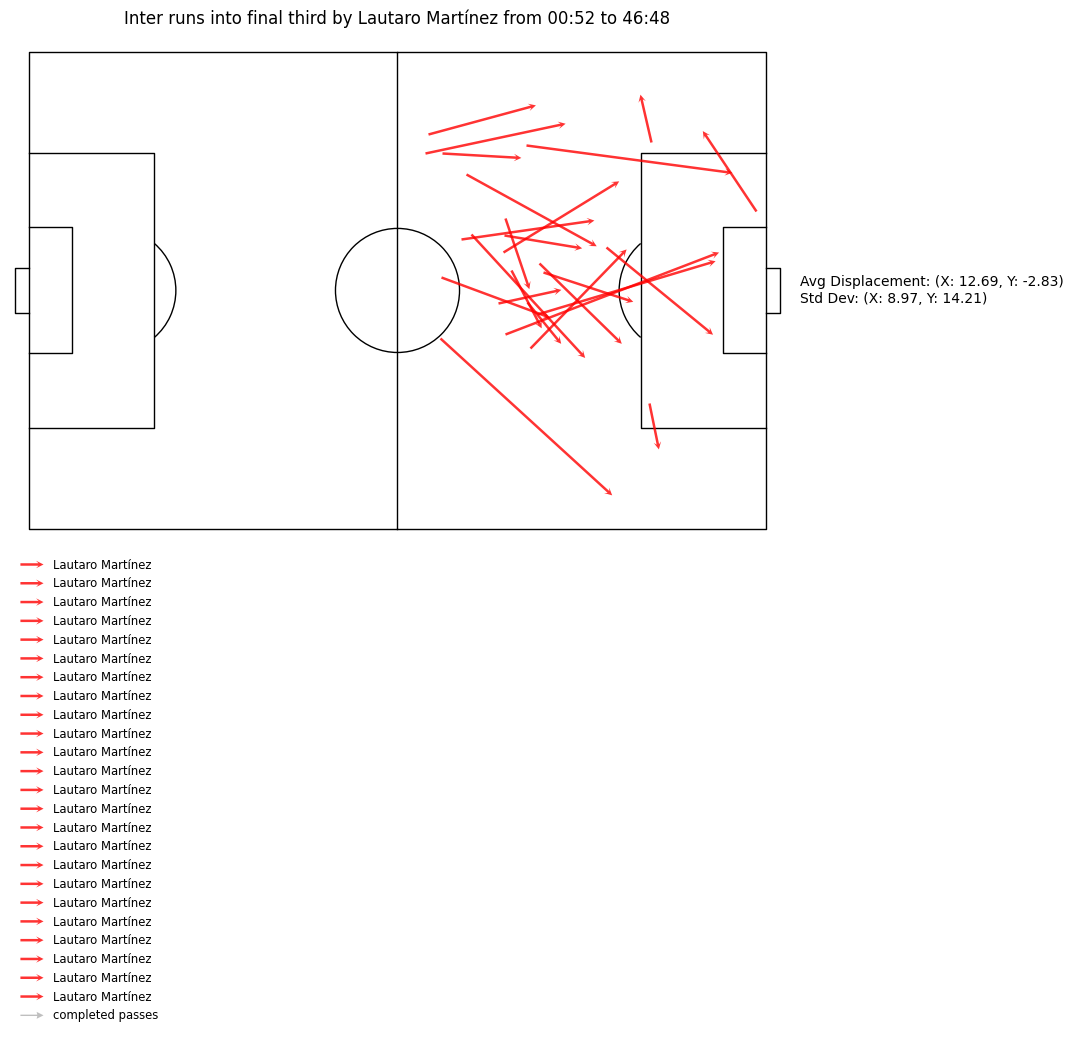

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


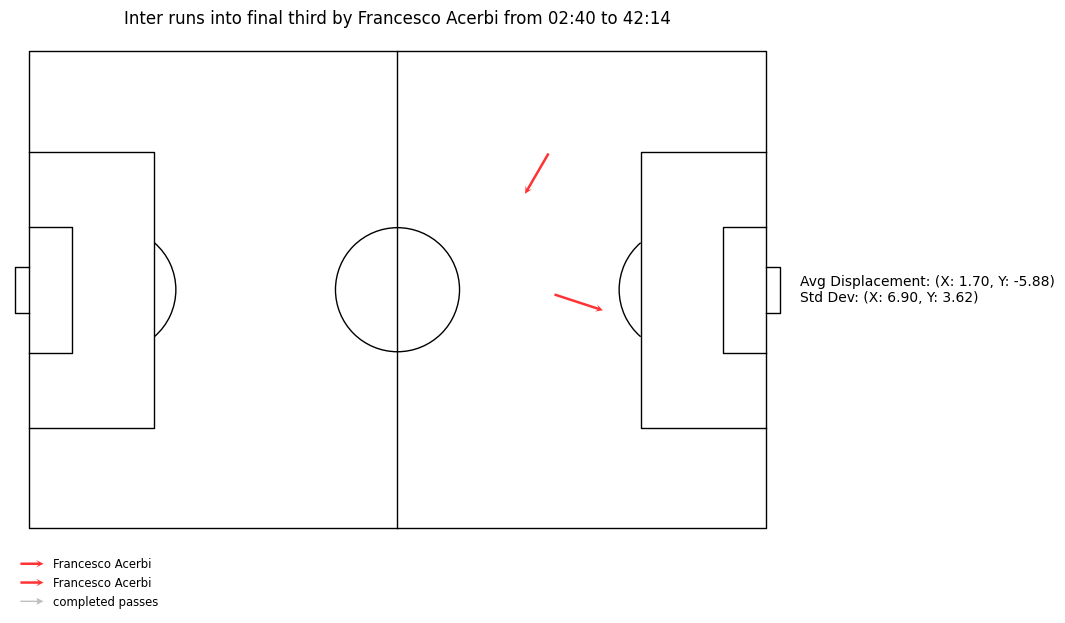

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


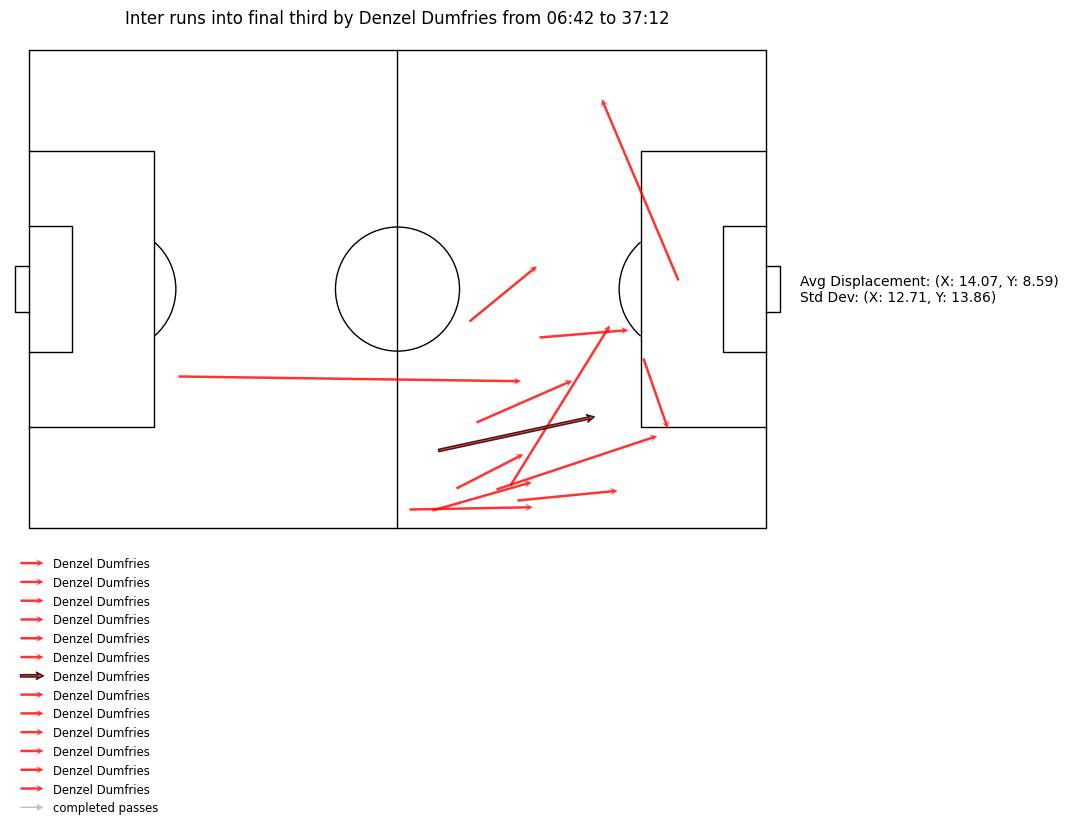

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


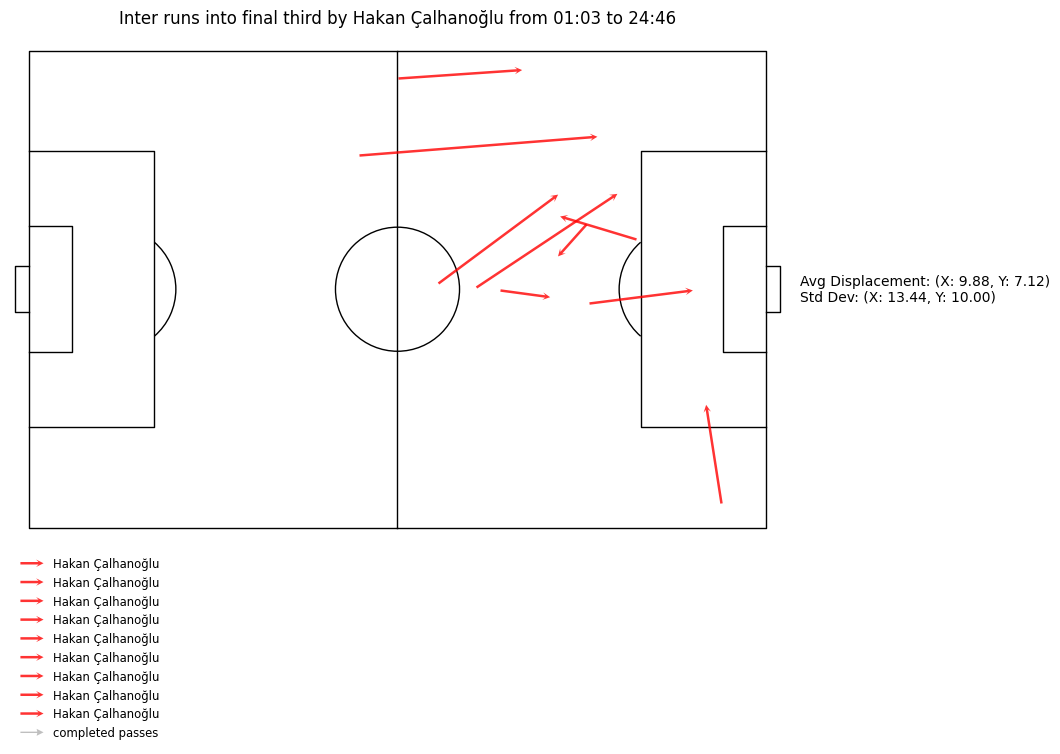

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


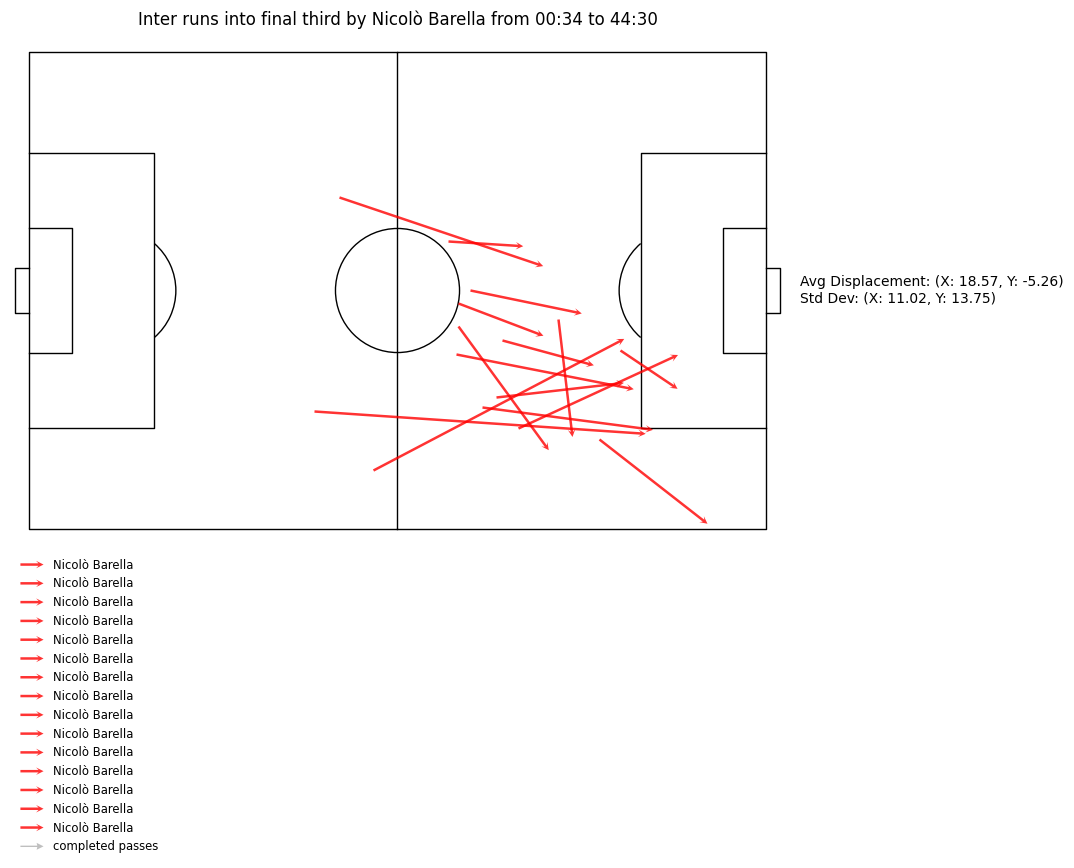

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


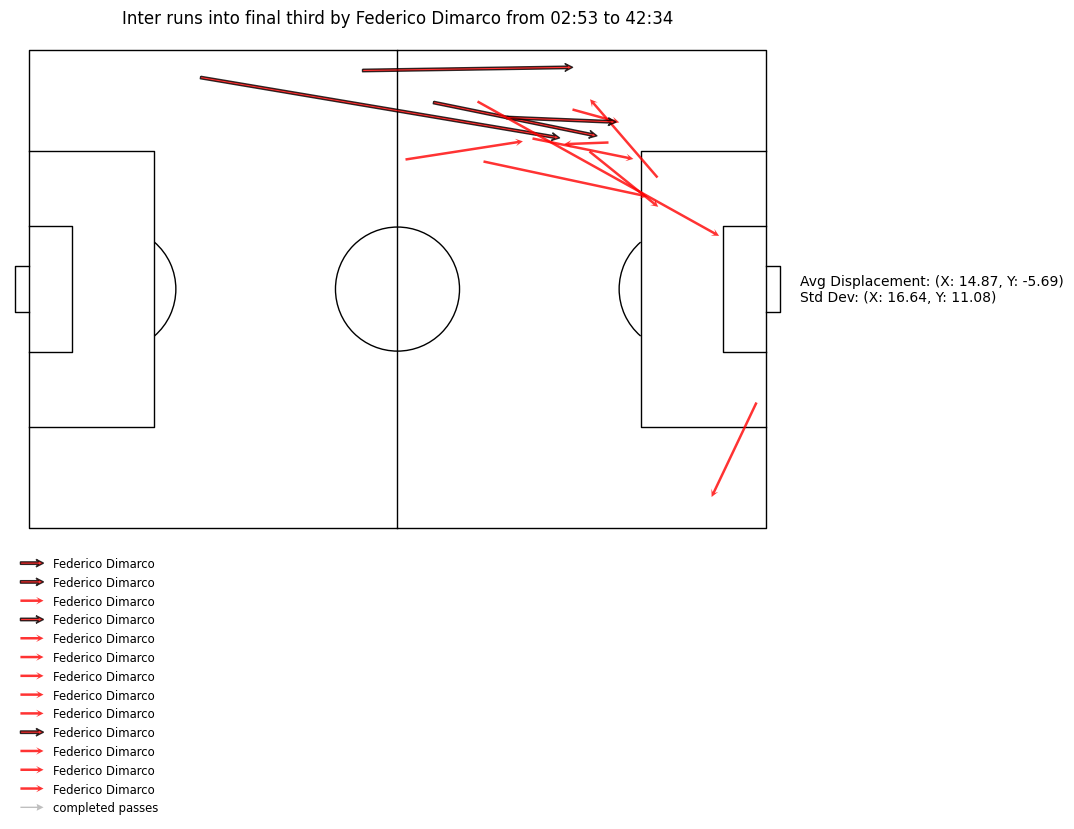

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


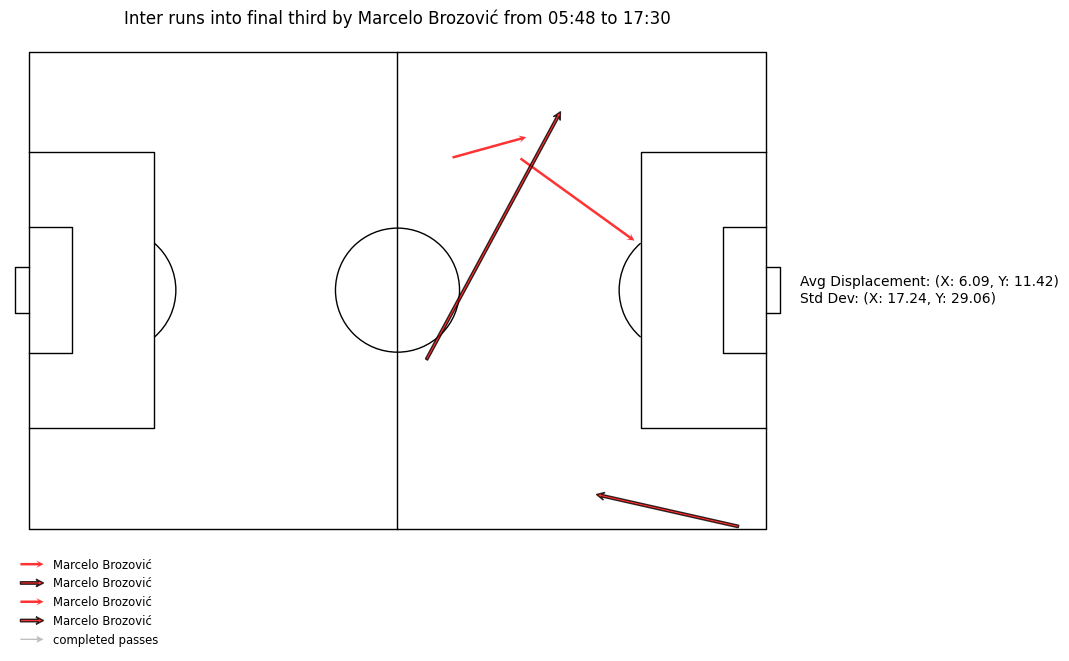

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


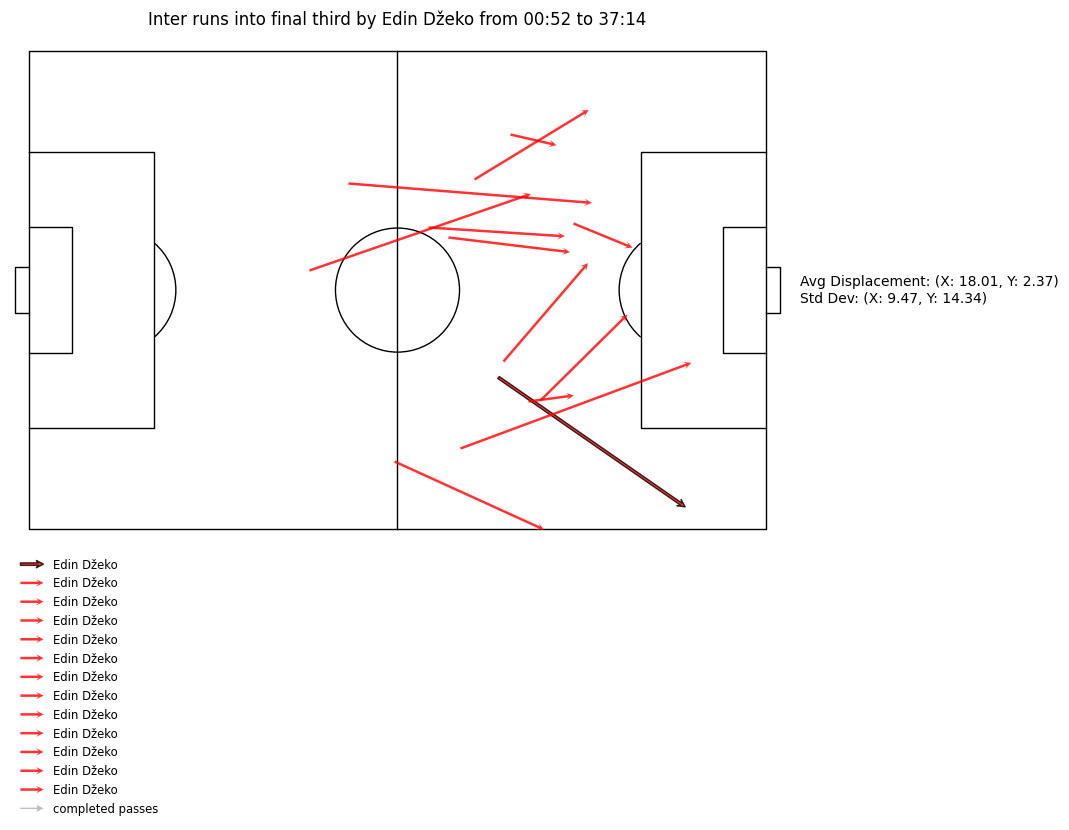

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


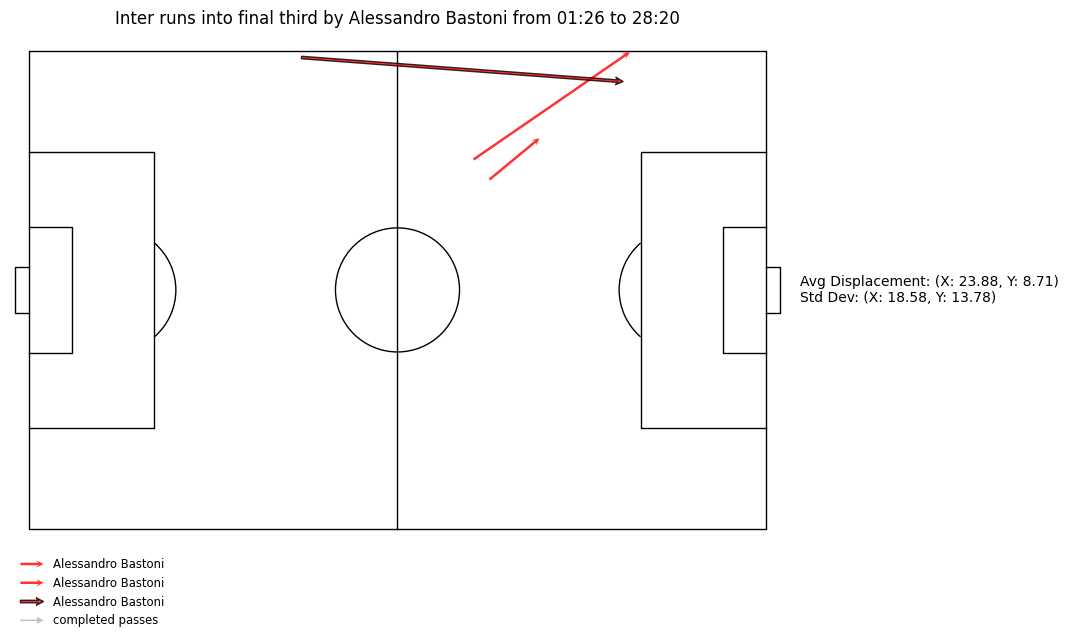

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


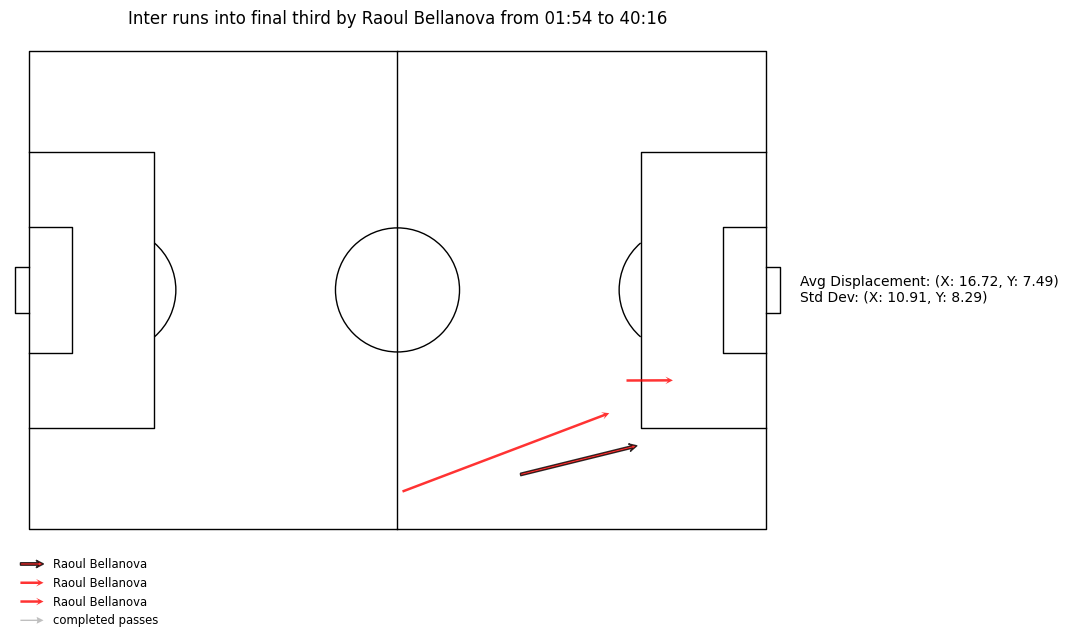

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


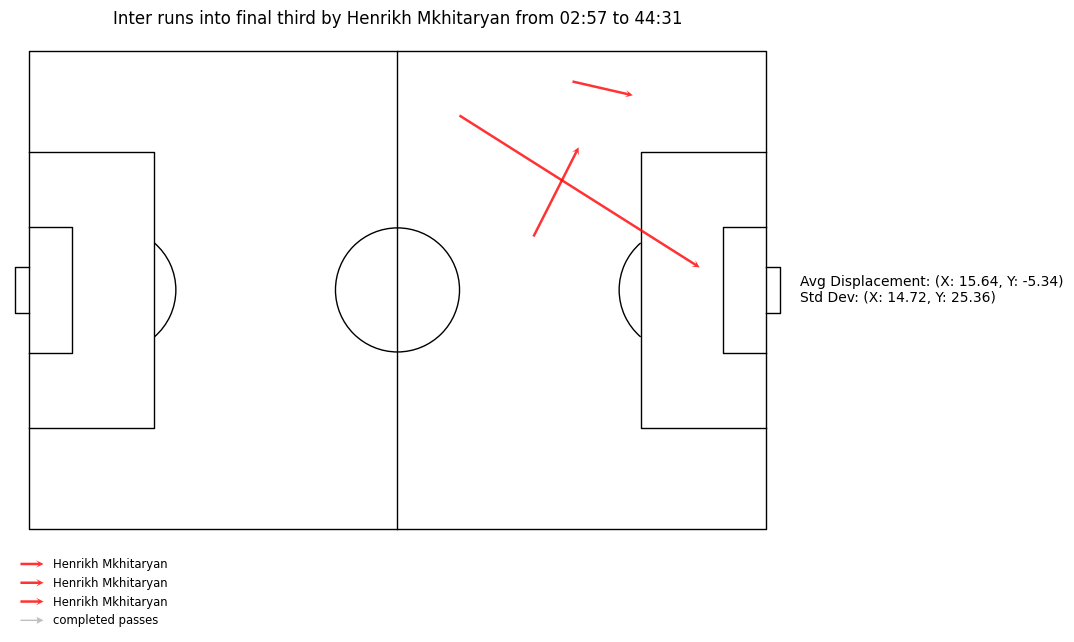

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


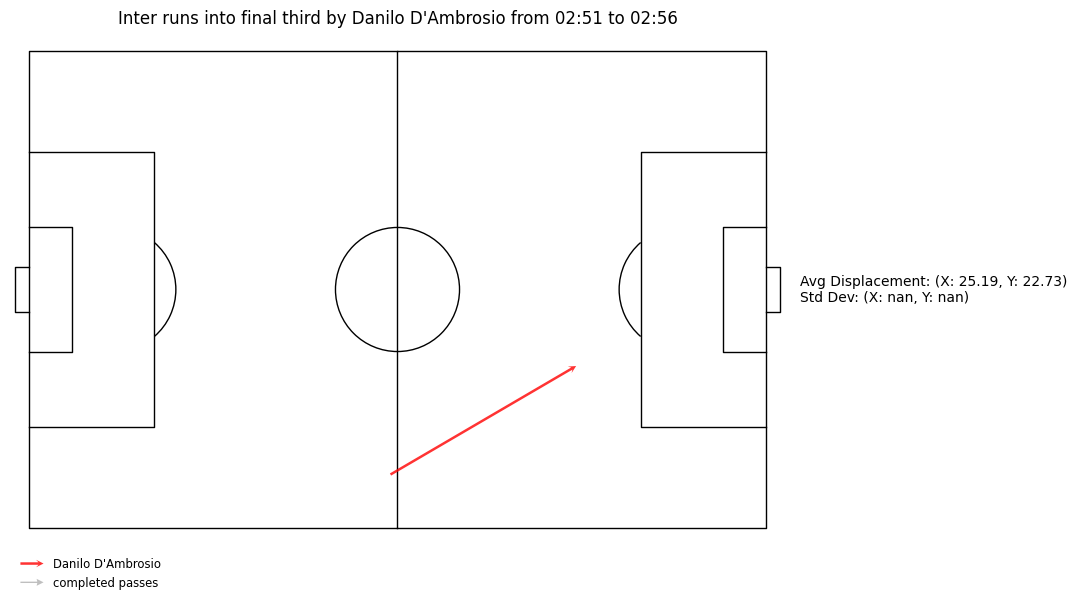

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


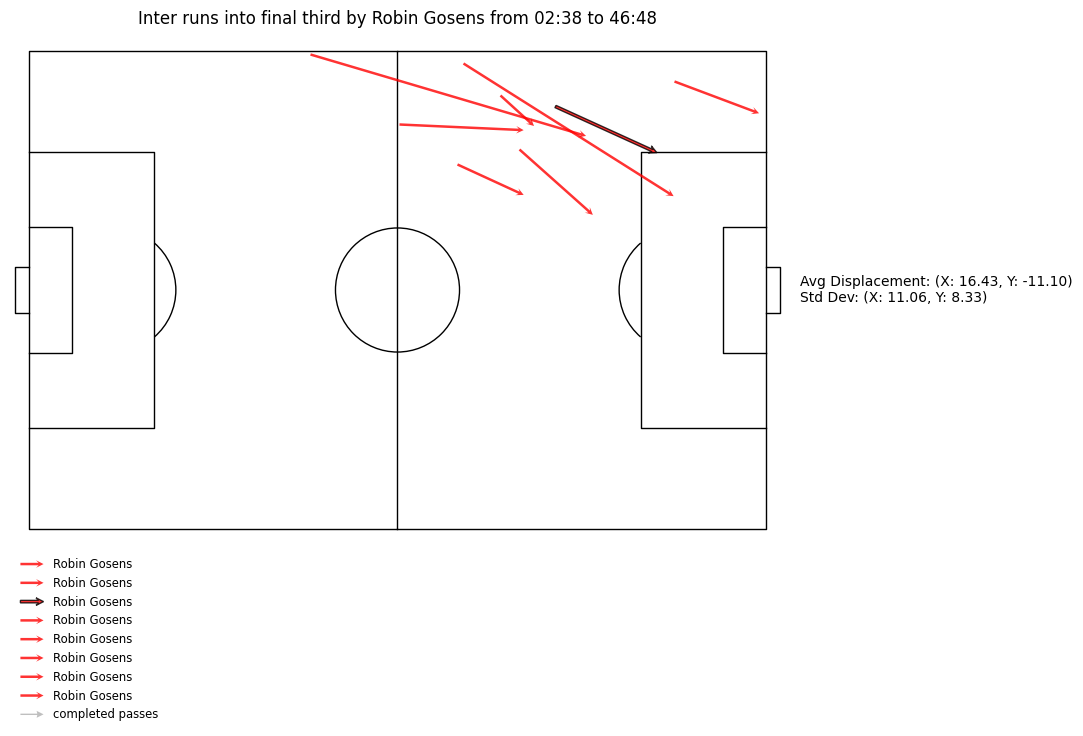

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_8797/93278302.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']


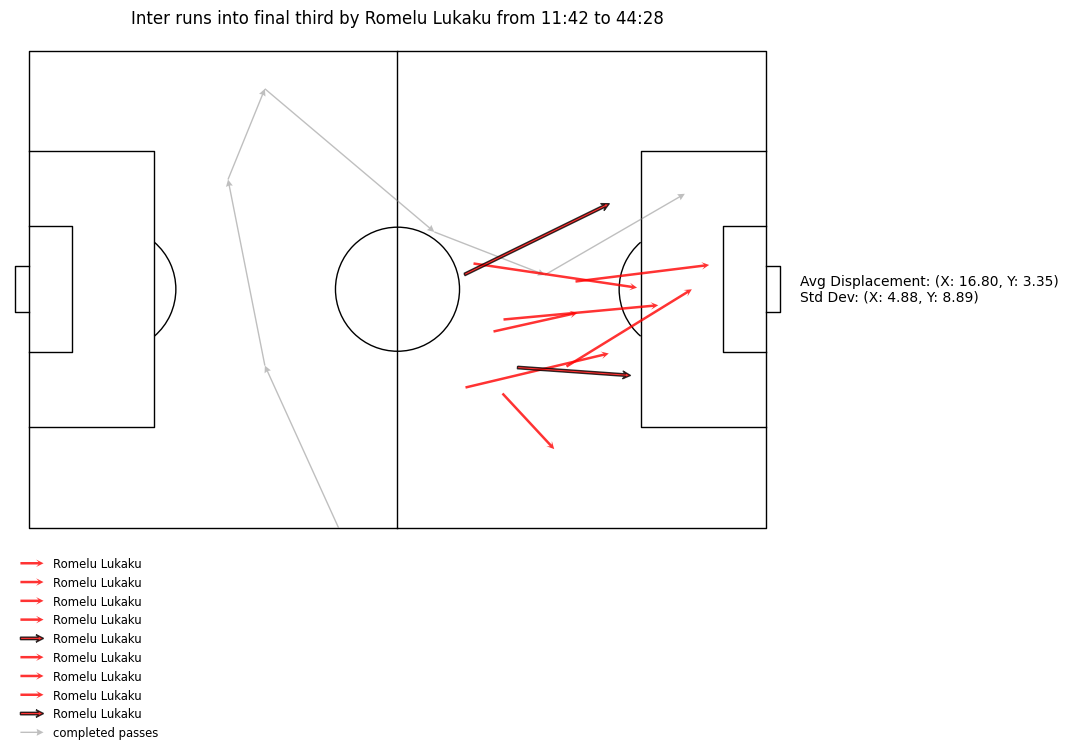

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.cm import get_cmap

# CL Finals
match_id = 18768058

# Load wyscout event data - Coordinates are transformed to opta
df_events = pd.read_parquet(f"data/tracking_data/{match_id}_stories.parquet")

# Load pre-generated "runs" data
df_runs = pd.read_parquet(f"data/tracking_data/{match_id}_runs.parquet")

# Find all runs in possession when shot occurs with xG > 0
xg_runs = df_runs[df_runs['xGRun'] > 0]

# Filter for runs into the final third of the pitch (end_x >= 66.6 assuming pitch is 100 units long)
final_third_runs = df_runs[df_runs['end_x'] >= 66.6]

# Set visualization parameters
visualize_passing_chain = True

# Get the list of unique players in final third runs
unique_players = final_third_runs['player'].unique()

# Loop through each player and plot their runs separately
for player in unique_players:
    
    # Filter for player's runs
    player_runs = final_third_runs[final_third_runs['player'] == player]
    
    # Compute displacement in X and Y directions for each run
    player_runs['displacement_x'] = player_runs['end_x'] - player_runs['start_x']
    player_runs['displacement_y'] = player_runs['end_y'] - player_runs['start_y']
    
    # Calculate average displacement (run direction) and standard deviation for X and Y
    avg_displacement_x = player_runs['displacement_x'].mean()
    avg_displacement_y = player_runs['displacement_y'].mean()
    std_displacement_x = player_runs['displacement_x'].std()
    std_displacement_y = player_runs['displacement_y'].std()
    
    # Plot all runs for the player
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
    pitch = Pitch(pitch_type="opta",
                  goal_type='box',
                  pitch_color="w",
                  linewidth=1,
                  spot_scale=0,
                  line_color="k",
                  line_zorder=1)

    pitch.draw(ax)

    # Define a fixed color for all runs
    run_color = 'red'  # You can change this to any color you prefer

    # Plot all runs for the player
    for idx, row in player_runs.iterrows():

        # Visualize runs with a fixed color
        pitch.arrows(row['start_x'], row['start_y'],
                          row['end_x'], row['end_y'],
                          width=1.8,
                          headwidth=3, headlength=3, headaxislength=2,
                          color=run_color,
                          edgecolor= "k" if row['Target'] else run_color,  # Differentiate target and off target runs
                          linewidth=1 if row['Target'] else 0,  # Differentiate target and off target runs
                          alpha=0.8,
                          zorder=3,
                          label=row['player'],
                          ax=ax)

    # Visualize possession chain if required
    if visualize_passing_chain:
        df_possession = df_events[(df_events['possession_id'] == row['possession_id']) & 
                                  (df_events['possession_team_id'] == df_events['team_id'])]
        pitch.arrows(df_possession[df_possession['end_x'].between(1, 100)]['start_x'],
                         df_possession[df_possession['end_x'].between(1, 100)]['start_y'],
                         df_possession[df_possession['end_x'].between(1, 100)]['end_x'],
                         df_possession[df_possession['end_x'].between(1, 100)]['end_y'], 
                         width=1, headwidth=5, alpha=0.5, ls='--', zorder=2,
                         headlength=5, color='grey', ax=ax, label='completed passes')

    # Add title
    possession_start_time = player_runs['time_start'].min()[0:5]
    possession_end_time = player_runs['time_end'].max()[0:5]
    team_name = player_runs.iloc[0]['team_name']
    ax.set_title(f"{team_name} runs into final third by {player} from {possession_start_time} to {possession_end_time}")

    # Add the label for average displacement and variation (std deviation)
    avg_displacement_label = (f"Avg Displacement: (X: {avg_displacement_x:.2f}, Y: {avg_displacement_y:.2f})\n"
                              f"Std Dev: (X: {std_displacement_x:.2f}, Y: {std_displacement_y:.2f})")
    ax.text(1.02, 0.5, avg_displacement_label, transform=ax.transAxes, fontsize=10, verticalalignment='center')

    # Legend
    ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize='small', framealpha=0.0, ncol=1)

    # Save output image for each player
    # Uncomment the next line to save the images
    # plt.savefig(f"outputs/{team_name}_{player}_final_third_runs.png")
    
    # Display the plot
    plt.show()


### Feature Engineering

In [37]:
df_runs.columns

Index(['player_id', 'jersey', 'team', 'frame_start', 'frame_end', 'start_x',
       'start_y', 'end_x', 'end_y', 'max_speed', 'avg_speed', 'player',
       'period', 'time_start', 'time_end', 'team_name', 'attacking_right',
       'wy_player_id', 'team_id', 'approx_time_start', 'approx_time_end',
       'Forward runs', 'Distance', 'Runs into box', 'xGRun',
       'In possession runs', 'possession_id', 'Target'],
      dtype='object')

Run Length

In [40]:
df_runs_features = df_runs.copy()

df_runs_features['run_length'] = np.sqrt((df_runs_features['end_x'] - df_runs_features['start_x'])**2 + 
                                    (df_runs_features['end_y'] - df_runs_features['start_y'])**2)
print(df_runs_features['run_length'].mean())
print(df_runs_features['run_length'].std())


18.433169234333654
10.145546174662286


Verticality of Run: Proportion of movement directed forward

In [50]:
df_runs_features['displacement_x'] = df_runs_features['end_x'] - df_runs_features['start_x']
df_runs_features['forwardness'] = df_runs_features['displacement_x'] / df_runs_features['run_length']
df_runs_features['forwardness'].min()

-0.9999993608680906

Goalward movement

In [47]:
# Assuming goal is at x=100 (adjust depending on your pitch scaling)
df_runs_features['goal_distance_start'] = 100 - df_runs_features['start_x']
df_runs_features['goal_distance_end'] = 100 - df_runs_features['end_x']
df_runs_features['goalward_movement'] = df_runs_features['goal_distance_start'] - df_runs_features['goal_distance_end']
df_runs_features['goalward_movement'].mean()

0.07987183943114007

Run Angle Relative to goal line

In [56]:
df_runs_features['angle_to_goal'] = np.arctan2(df_runs_features['end_y'] - df_runs_features['start_y'], 
                                          100 - df_runs_features['start_x'])  # Assuming goal at x=100
np.degrees(df_runs_features['angle_to_goal'].mean())

-0.08836056429207405

In [58]:
# Show all columns in the DataFrame
pd.set_option('display.max_columns', None)
df_events

,id,player_id,team_id,minute,second,period,start_x,start_y,end_x,end_y,cutback,switch,successful,video_start,possession_team_id,possession_id,time_diff,pass_accurate,shot_xg,shot_xgot,pass_length,possession_duration,first_event,event_index,possession_events,type,shot_goal,shot_body_part,shot_on_target,shot_on_post,shot_off_target,shot_blocked,pass_high,pass_low,pass_blocked,pass_recipient_id,possession_xg,possession_goal,player_position,xA,xT_start,xT_end,take_on,stopped_progress,recovered_possession,retain_possession,kept_possession,progressed_with_ball,aerial_won,match_state,team_win_state,possession_state,xg_after_5s,shot_id,pass,back_pass,short_or_medium_pass,forward_pass,loss,pass_to_final_third,progressive_pass,recovery,smart_pass,offside,free_kick,lateral_pass,acceleration,progressive_run,carry,cross,pass_to_penalty_area,interception,game_interruption,ball_out,corner,head_pass,shot,head_shot,opportunity,shot_after_corner,touch_in_box,goal_kick,long_pass,under_pressure,duel,aerial_duel,defensive_duel,ground_duel,offensive_duel,touch,throw_in,loose_ball_duel,counterpressing_recovery,clearance,foul_suffered,infraction,foul,shot_after_throw_in,shot_against,save,sliding_tackle,free_kick_cross,save_with_reflex,deep_completion,dribble,hand_pass,through_pass,dribbled_past_attempt,goalkeeper_exit,shot_assist,yellow_card,linkup_play,cross_blocked,deep_completed_cross,shot_block,second_assist,assist,key_pass,goal,conceded_goal,third_assist,fairplay,whistle,free_kick_shot,shot_after_free_kick,own_goal,penalty_foul,penalty,penalty_goal,penalty_conceded_goal,red_card,penalty_save,possession_set_piece_attack,possession_attack,possession_free_kick,possession_corner,possession_throw_in,possession_transition_low,possession_free_kick_cross,possession_transition_high,possession_transition_medium,possession_counterattack,possession_direct_free_kick,possession_penalty,match_time,approx_match_time,season,match_id,competition,possession_team
82,1670470694,11051,1625,4,51,1,76,80,70,69,False,False,True,292.816772,1625,1670470679,1.328,True,0.0000,0.0000,10,39.868015,False,11,21,pass,False,,False,False,False,False,False,False,False,14808,0.0615,False,LW,0.0000,0.0273,0.0227,False,None,None,NaN,None,None,False,0,-1,attack,0.0000,0,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,291,286650.0,2022,5345058,108,home_team
83,1670470696,14808,1625,4,52,1,70,69,78,55,False,False,True,293.830383,1625,1670470679,1.014,False,0.0000,0.0000,0,39.868015,False,12,21,touch,False,,False,False,False,False,False,False,False,0,0.0615,False,LCMF3,0.0000,0.0227,0.0386,False,None,None,NaN,None,None,False,0,-1,attack,0.0000,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,292,287664.0,2022,5345058,108,home_team
84,1670470697,14808,1625,4,54,1,78,55,78,43,False,False,True,295.614105,1625,1670470679,1.784,True,0.0000,0.0000,8,39.868015,False,13,21,pass,False,,False,False,False,False,False,False,False,9380,0.0615,False,LCMF3,0.0000,0.0285,0.0400,False,None,None,NaN,None,None,False,0,-1,attack,0.0000,0,True,False,True

In [59]:
df_runs

,player_id,jersey,team,frame_start,frame_end,start_x,start_y,end_x,end_y,max_speed,avg_speed,player,period,time_start,time_end,team_name,attacking_right,wy_player_id,team_id,approx_time_start,approx_time_end,Forward runs,Distance,Runs into box,xGRun,In possession runs,possession_id,Target
0,home_team_player_10,10,home_team,1279,1357,54.198198,81.201682,35.902647,91.648976,25.990283,19.880053,Jack Grealish,1,00:51.160000,00:54.280000,Manchester City,away_team,11051,1625,51160.0,54280.0,False,20.481841,False,0.0000,False,1670469650,False
1,home_team_player_10,10,home_team,7216,7250,78.752550,74.942682,84.251781,66.981610,21.529320,19.820071,Jack Grealish,1,04:48.640000,04:50.000000,Manchester City,away_team,11051,1625,288640.0,290000.0,True,7.915024,True,0.0615,True,1670470679,False
2,home_team_player_10,10,home_team,14178,14250,59.866674,82.591450,71.969354,61.423390,26.396568,20.014536,Jack Grealish,1,09:27.120000,09:30.000000,Manchester City,away_team,11051,1625,567120.0,570000.0,False,19.201143,False,0.0000,False,1670469841,False
3,home_team_player_10,10,home_team,14378,14419,68.775642,62.520785,63.918346,73.883564,20.566030,19.832886,Jack Grealish,1,09:35.120000,09:36.760000,Manchester City,away_team,11051,1625,575120.0,576760.0,False,9.258152,False,0.0000,False,1670469841,False
4,home_team_player_10,10,home_team,14633,14668,27.751955,65.643166,20.801524,61.318118,20.471871,19.804934,Jack Grealish,1,09:45.320000,09:46.720000,Manchester City,away_team,11051,1625,585320.0,586720.0,False,7.868277,False,0.0000,False,1670469841,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,away_team_player_90,90,away_team,53902,53931,13.984942,55.936805,20.897677,54.118610,25.211134,19.963199,Romelu Lukaku,2,35:56.080000,35:57.240000,Inter,home_team,7905,3161,2156080.0,2157240.0,False,7.362919,False,0.0000,False,-1,False
801,away_team_player_90,90,away_team,55470,55521,62.981050,41.170225,74.366433,45.089315,22.486086,19.940099,Romelu Lukaku,2,36:58.800000,37:00.840000,Inter,home_team,7905,3161,2218800.0,2220840.0,False,12.248095,False,0.0000,False,-1,False
802,away_team_player_90,90,away_team,59687,59741,48.662180,37.113397,60.468578,38.319543,21.243508,19.801474,Romelu Lukaku,2,39:47.480000,39:49.640000,Inter,home_team,7905,3161,2387480.0,2389640.0,False,12.423820,False,0.0000,False,1670470402,False
803,away_team_player_90,90,away_team,60312,60394,64.251141,43.782475,85.251951,46.768044,26.539280,19.814845,Romelu Lukaku,2,40:12.480000,40:15.760000,Inter,home_team,7905,3161,2412480.0,2415760.0,True,22.144112,True,0.0000,True,1670471691,False


Proximity to touchline

In [60]:
# Assuming 'start_y' and 'end_y' are the Y-coordinates of the start and end points of the run

def touchline_proximity(start_y, end_y):
    # Touchlines are at Y = 0 (bottom) and Y = 100 (top)
    
    # Distance to nearest touchline at the start of the run
    distance_to_touchline_start = min(abs(start_y - 0), abs(start_y - 100))
    
    # Distance to nearest touchline at the end of the run
    distance_to_touchline_end = min(abs(end_y - 0), abs(end_y - 100))
    
    # Calculate the change in distance to the nearest touchline
    change_in_distance = distance_to_touchline_end - distance_to_touchline_start
    
    # If change_in_distance is negative, the player is moving towards the touchline
    # If change_in_distance is positive, the player is moving away from the touchline
    return change_in_distance

# Apply the function to your DataFrame
final_third_runs['touchline_proximity'] = final_third_runs.apply(lambda row: touchline_proximity(row['start_y'], row['end_y']), axis=1)

# Analyze the results
print(final_third_runs[['player', 'start_y', 'end_y', 'touchline_proximity']])


            player    start_y      end_y  touchline_proximity
1    Jack Grealish  74.942682  66.981610             7.961073
2    Jack Grealish  82.591450  61.423390            21.168060
6    Jack Grealish  96.918281  84.702034            12.216247
7    Jack Grealish  98.810993  78.139737            20.671257
8    Jack Grealish  79.442809  89.191060            -9.748251
..             ...        ...        ...                  ...
797  Romelu Lukaku  33.747593  32.081295            -1.666297
798  Romelu Lukaku  55.560586  50.493831             5.066755
801  Romelu Lukaku  41.170225  45.089315             3.919091
803  Romelu Lukaku  43.782475  46.768044             2.985569
804  Romelu Lukaku  53.192224  68.024752           -14.832528

[244 rows x 4 columns]


/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_5567/1929860635.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_third_runs['touchline_proximity'] = final_third_runs.apply(lambda row: touchline_proximity(row['start_y'], row['end_y']), axis=1)
